In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import matplotlib
import wandb
import torch.nn as nn
import torchvision.transforms as tform
import torch.optim as optim
import aslxplane.perception.models as xplane_models
from torch.utils.data import Dataset, DataLoader
from tqdm import trange, tqdm
from PIL import Image
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=20)
plt.rc('font', family='Times New Roman')
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'
%autoreload 2

In [3]:
data_dir = "../../Xplane-data-dir/xplane-asl-test/sinusoids-03-08-23/"
label_file = "labels.csv"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load label file and plot some dataset statistics

In [4]:
df = pd.read_csv(data_dir + label_file)
df[:5]

,image_filename,absolute_time_GMT_seconds,relative_time_seconds,distance_to_centerline_meters,distance_to_centerline_NORMALIZED,downtrack_position_meters,downtrack_position_NORMALIZED,heading_error_degrees,heading_error_NORMALIZED,speed_meters_per_second,period_of_day,cloud_type,image_corruption
0,MWH_Runway04_morning_clear_0_0.png,68081.203125,0.000000,0.007486,0.000749,15.338386,0.514366,0.002177,0.000073,5.015036,0,0,0
1,MWH_Runway04_morning_clear_0_1.png,68081.562500,0.359375,0.012615,0.001261,17.106638,0.573663,-0.378392,-0.012613,4.997900,0,0,0
2,MWH_Runway04_morning_clear_0_2.png,68081.906250,0.703125,-0.010726,-0.001073,18.914559,0.634291,-1.499875,-0.049996,4.995921,0,0,0
3,MWH_Runway04_morning_clear_0_3.png,68082.242188,1.039062,-0.063710,-0.006371,20.576195,0.690013,-3.087132,-0.102904,4.997653,0,0,0
4,MWH_Runway04_morning_clear_0_4.png,68082.585938,1.382812,-0.166725,-0.016673,22.274047,0.746950,-5.061215,-0.168707,5.002153,0,0,0


# Set Model Architecture

In [5]:
model_params = {
    "type": "auto-model",
    "image_size": (16,32),
    "hidden_layers": (128, 64, 16)
}

# Construct Dataset and Dataloader

In [58]:
class TaxiNet(Dataset):

    def __init__(self, df, data_dir, label_file, image_size, max_samples=None):
        self.data_dir = data_dir
        self.label_file = label_file
        self.df = df
        self.max_samples = max_samples
        self.morning_images = df.index[df["image_filename"].str.contains("morning")].to_list()
        self.resize_and_grayscale = tform.Compose([
            tform.Resize(size=image_size),
            tform.Grayscale(),
            tform.ToTensor()
        ])
        
    def __len__(self):
        return len(self.morning_images) if self.max_samples is None else self.max_samples

    def __getitem__(self, idx):
        data_idx = self.morning_images[idx]
        img_file = df.loc[data_idx, "image_filename"]
        y_cte = df.loc[data_idx, "distance_to_centerline_NORMALIZED"]
        y_he = df.loc[data_idx, "heading_error_NORMALIZED"]
        img = Image.open(data_dir + img_file)
        return torch.tensor([y_cte, y_he]), self.resize_and_grayscale(img)
    

In [59]:
dataset = TaxiNet(df, data_dir, label_file, model_params["image_size"])

dataset contains 85596 points


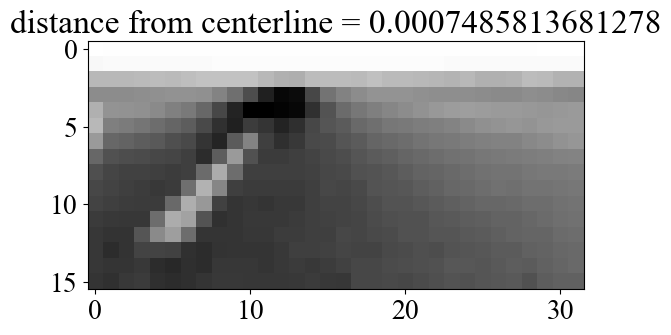

In [60]:
y, img = dataset[0]
plt.imshow(tform.ToPILImage()(img), cmap="gray")
plt.title(f"distance from centerline = {y[0]}")
print("dataset contains %d points" % len(dataset))

# Setup Training

In [89]:
train_split = int(.8 * len(dataset))
val_split = len(dataset) - train_split
train_data, val_data = torch.utils.data.random_split(dataset, [train_split, val_split])

In [90]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32)

In [91]:
model = xplane_models.AutoEncoder(model_params).to(device)


In [92]:
learning_params = {
    "num_epochs": 10, 
    "num_train_steps":1000, 
    "learning_rate":1e-1, 
    "compute_val":500
}

optimizer = optim.Adam(
    model.parameters(),
    lr=learning_params["learning_rate"],
    # weight_decay=1e-3
)

scheduler = optim.lr_scheduler.LambdaLR(
    optimizer, 
    lambda i: max(learning_params["learning_rate"] * (.1 ** (int(np.floor(i / 3)))), 1e-4)
)

In [93]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="asl-closed-loop-monitor",
    
    # track hyperparameters and run metadata
    config={
    "architecture": "Automodel",
    "dataset": data_dir.split("/")[-2],
    "output": "ReconStruction"
    }
)

In [94]:
def get_loss(model, X, y, loss_func):
    X = X.to(device)
    pred = model(X).unsqueeze(1)
    loss = loss_func(pred, X)
    return loss

def train(model, optimizer, train_data, val_data, scheduler, learning_params=None):
    train_losses = []
    val_losses = [-1]
    epochs = trange(learning_params["num_epochs"], desc='Current Loss = ', leave=True)
    loss_func = nn.MSELoss()
    for i in epochs:
        for j, (y, X) in enumerate(train_data):
            if j > learning_params["num_train_steps"]:
                break
            
            optimizer.zero_grad()
        
            loss = get_loss(model, X, y, loss_func)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            epochs.set_description("Current batch Loss = %.2f, Current Val Loss = %.2f" % (loss.item(), val_losses[-1]))
            wandb.log({"loss":loss.item(), "val_loss":val_losses[-1]})
        with torch.no_grad():
            val_losses_list = []
            for y, X in val_data:
                val_losses_list.append(get_loss(model, X, y, loss_func).item())
            val_losses.append(np.mean(val_losses_list))
            
        scheduler.step()
            
    return np.vstack(train_losses).flatten(), np.vstack(val_losses[1:]).flatten()

In [95]:
train_losses, val_losses = train(
    model, 
    optimizer,
    train_dataloader, 
    val_dataloader, 
    scheduler,
    learning_params=learning_params
)

Current batch Loss = 0.00, Current Val Loss = 0.00: 100%|██████████| 10/10 [15:37<00:00, 93.77s/it]


In [101]:
wandb.finish()

In [102]:
xplane_models.save_checkpoint(model_params, model.cpu(), "../data/models/", model_title="taxinet-autoencoder")

tensor(1.0372, grad_fn=<CopyBackwards>)
tensor(0.4081, grad_fn=<CopyBackwards>)
tensor(1.0113, grad_fn=<CopyBackwards>)
tensor(0.5841, grad_fn=<CopyBackwards>)
tensor(1.0106, grad_fn=<CopyBackwards>)
tensor(1.1637, grad_fn=<CopyBackwards>)
tensor(0.7857, grad_fn=<CopyBackwards>)
tensor(0.6383, grad_fn=<CopyBackwards>)


<Figure size 640x480 with 0 Axes>

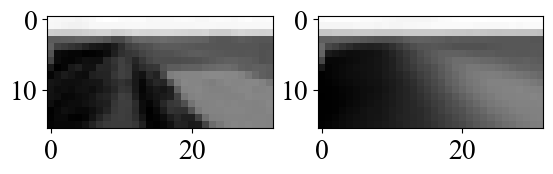

<Figure size 640x480 with 0 Axes>

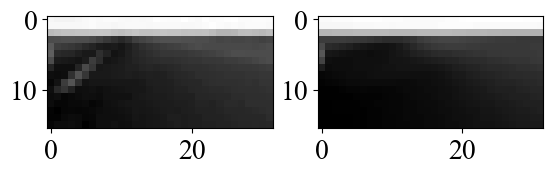

<Figure size 640x480 with 0 Axes>

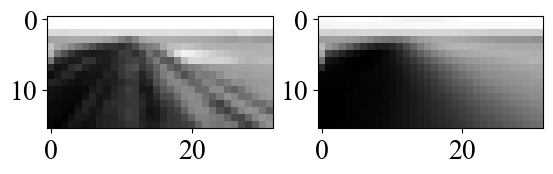

<Figure size 640x480 with 0 Axes>

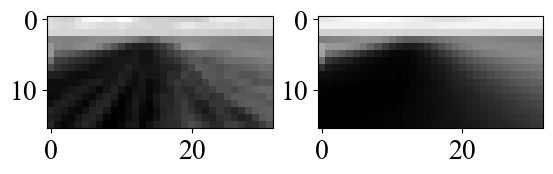

<Figure size 640x480 with 0 Axes>

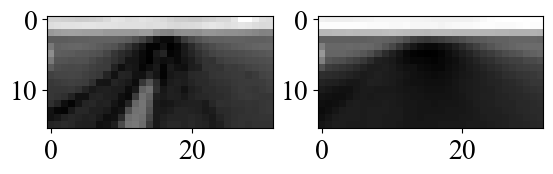

<Figure size 640x480 with 0 Axes>

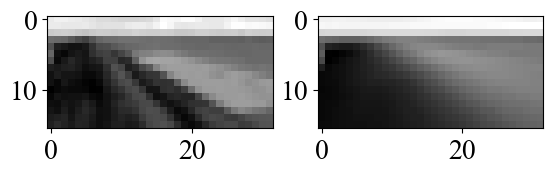

<Figure size 640x480 with 0 Axes>

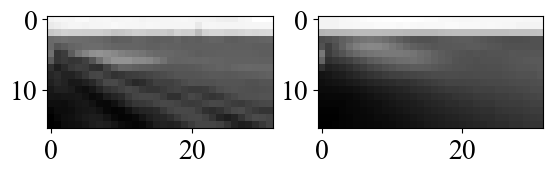

<Figure size 640x480 with 0 Axes>

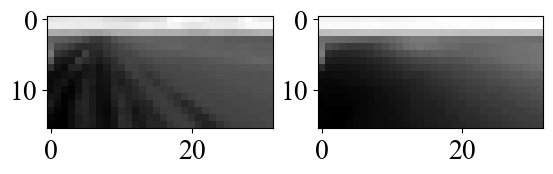

In [103]:
model.cpu()
for i in [0, 10,20,30, 100, 1000, 2000, 8000]:
    plt.figure()
    y, X = val_data[i]
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(tform.ToPILImage()(X), cmap="gray")
    axs[1].imshow(tform.ToPILImage()(model(X)), cmap="gray")
    print(torch.norm(X - model(X)))

In [69]:
int(np.floor(4/2))

2

In [99]:
n_samples = len(val_data)
reconstruction_errors = []
for i in range(n_samples):
    y, X = val_data[i]
    reconstruction_errors.append(torch.norm(X - model(X)).detach().numpy())

Text(0, 0.5, 'density')

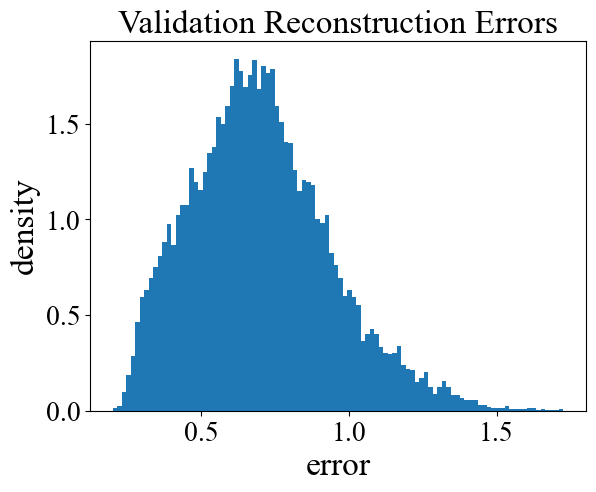

In [100]:
plt.hist(reconstruction_errors, bins=100, density=True)
plt.title("Validation Reconstruction Errors")
plt.xlabel("error")
plt.ylabel("density")